In [1]:
import torch
import numpy as np
import torch.nn as nn
import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda
import matplotlib.pyplot as plt
from torchinfo import summary
import cv2 as cv
from torch.utils.tensorboard import SummaryWriter

In [2]:
def L_rate(ep, lr):
    learning_rate = lr
    if ep<10:
        learning_rate = lr
    elif ep>15 and ep<25:
        learning_rate = lr/10
    elif ep>25 and ep<40:
        learning_rate = lr/50
    elif ep>40 and ep<60:
        learning_rate = lr/100
    elif ep>60:
        learning_rate = lr/500
    return learning_rate

def train(net,train_loader,test_loader,optimizer=None,lr=0.01,epochs=10,loss_fn=nn.NLLLoss(), writer = None, device = None):
    res = { 'train_loss' : [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    for ep in range(epochs):
        lr = 1e-3
        learning_rate = L_rate(ep+1, lr)
        optimizer = torch.optim.SGD(net.parameters(), lr = learning_rate)
        net.train()
        writer.add_scalar("Learning Rate", learning_rate, ep)
        total_loss,acc,count = 0,0,0
        for batch_idx, (features,labels) in enumerate(train_loader):
            optimizer.zero_grad()
            features = features.to(device)
            labels = labels.to(device)
            out = net(features)
            loss = loss_fn(out,labels) #cross_entropy(out,labels)
            loss.backward()
            optimizer.step()
            total_loss+=loss
            _,predicted = torch.max(out,1)
            acc+=(predicted==labels).sum()
            count+=len(labels)
                
            if batch_idx%100 == 0:
                print('Train Epoch: {} [{:>5d}/{:>5d} ({:.0f}%)] \t\tLoss: {:.6f}'.format(
                    ep + 1,
                    batch_idx*len(features),
                    len(train_loader.dataset),
                    100. * batch_idx / len(train_loader),
                    loss.item()
                ))
                writer.add_scalar("Train Accuracy", acc.item()/count, ep*60000+count)
                writer.add_scalar("Train Loss", total_loss.item()/count, ep*6000 + count)
        tl, ta = total_loss.item()/count, acc.item()/count
        net.eval()
        t_count,t_acc,t_loss = 0,0,0
        with torch.no_grad():
            for t_features,t_labels in test_loader:
                t_features = t_features.to(device)
                t_labels = t_labels.to(device)
                t_out = net(t_features)
                t_loss += loss_fn(t_out,t_labels) 
                t_pred = torch.max(t_out,1)[1]
                t_acc += (t_pred==t_labels).sum()
                t_count += len(labels)
        vl, va = t_loss.item()/t_count, t_acc.item()/t_count
        print(f"-----------------------------------------\nEpoch {ep+1:2}, Train acc={ta:.3f}, Val acc={va:.3f}, Train loss={tl:.3f}, Val loss={vl:.3f}\n")
        res['train_loss'].append(tl)
        res['train_acc'].append(ta)
        res['val_loss'].append(vl)
        res['val_acc'].append(va)
    return res

def plot_results(hist):
    plt.figure(figsize=(15,5))
    plt.subplot(121)
    plt.plot(hist['train_acc'], label='Training acc')
    plt.plot(hist['val_acc'], label='Validation acc')
    plt.xlabel("epochs")
    plt.ylabel("acc")
    plt.ylim(0, 1)
    plt.legend()
    plt.subplot(122)
    plt.plot(hist['train_loss'], label='Training loss')
    plt.plot(hist['val_loss'], label='Validation loss')
    plt.xlabel("epochs")
    plt.ylabel("acc")
    plt.legend()
    
def img_to_torch(img):
    rows, cols = 28, 28
    img = cv.resize(img, (rows, cols), interpolation = cv.INTER_LINEAR)
    img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    for row in range(rows):
        for col in range(cols):
            img[row, col] = (255 - img[row, col])
    img = torch.from_numpy(img).unsqueeze(0)
    img = img.type(torch.FloatTensor)/255
    img = (img - 0.5)/0.5
    #img = img.permute(0, 1, 2)
    return img

def load_mnist(batch_size = 32):
    transform1 = torchvision.transforms.Compose(
        [torchvision.transforms.ToTensor(),
         torchvision.transforms.Normalize((0.5, ), (0.5, ))])
    train_data = torchvision.datasets.MNIST(
        root = './data',
        download = True,
        train = True,
        transform = transform1
    )
    test_data = torchvision.datasets.MNIST(
        root = './data',
        download = True,
        train = False,
        transform = transform1
    )
    train_loader = torch.utils.data.DataLoader(train_data, batch_size = batch_size)
    test_loader = torch.utils.data.DataLoader(test_data, batch_size = batch_size)
    
    return train_data, test_data, train_loader, test_loader
        

In [5]:
device = 'cpu'

class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10),
            nn.ReLU()   
        )

    def forward(self, x):
        x = self.flatten(x)
        x = self.linear_relu_stack(x)
        return x

model = NeuralNetwork().to(device)

In [6]:
summary(model, input_size = (1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
NeuralNetwork                            [1, 10]                   --
├─Flatten: 1-1                           [1, 784]                  --
├─Sequential: 1-2                        [1, 10]                   --
│    └─Linear: 2-1                       [1, 512]                  401,920
│    └─ReLU: 2-2                         [1, 512]                  --
│    └─Linear: 2-3                       [1, 512]                  262,656
│    └─ReLU: 2-4                         [1, 512]                  --
│    └─Linear: 2-5                       [1, 10]                   5,130
│    └─ReLU: 2-6                         [1, 10]                   --
Total params: 669,706
Trainable params: 669,706
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.67
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 2.68
Estimated Total Size (MB): 2.69

In [7]:
train_data, test_data, train_loader, test_loader= load_mnist()
learning_rate = 1e-3
log_dir = "./DenseMnist/"
writer = SummaryWriter(log_dir)

hist = train(model, train_loader, test_loader, lr=learning_rate, epochs=20, loss_fn=nn.CrossEntropyLoss(), writer = writer)
plot_results(hist)
writer.close()

Train Epoch: 1 [    0/60000 (0%)] 		Loss: 2.305138
Train Epoch: 1 [ 3200/60000 (5%)] 		Loss: 2.302125
Train Epoch: 1 [ 6400/60000 (11%)] 		Loss: 2.280019
Train Epoch: 1 [ 9600/60000 (16%)] 		Loss: 2.280766
Train Epoch: 1 [12800/60000 (21%)] 		Loss: 2.278097
Train Epoch: 1 [16000/60000 (27%)] 		Loss: 2.256452
Train Epoch: 1 [19200/60000 (32%)] 		Loss: 2.207732
Train Epoch: 1 [22400/60000 (37%)] 		Loss: 2.198204
Train Epoch: 1 [25600/60000 (43%)] 		Loss: 2.196246
Train Epoch: 1 [28800/60000 (48%)] 		Loss: 2.139097
Train Epoch: 1 [32000/60000 (53%)] 		Loss: 2.181269
Train Epoch: 1 [35200/60000 (59%)] 		Loss: 2.107546
Train Epoch: 1 [38400/60000 (64%)] 		Loss: 2.086247
Train Epoch: 1 [41600/60000 (69%)] 		Loss: 2.057152
Train Epoch: 1 [44800/60000 (75%)] 		Loss: 2.110126
Train Epoch: 1 [48000/60000 (80%)] 		Loss: 2.053867
Train Epoch: 1 [51200/60000 (85%)] 		Loss: 2.028316
Train Epoch: 1 [54400/60000 (91%)] 		Loss: 1.951165
Train Epoch: 1 [57600/60000 (96%)] 		Loss: 1.923434
--------------

In [8]:
torch.save(model.state_dict(), "data/model.pth")
print("Saved PyTorch Model State to model.pth")

Saved PyTorch Model State to model.pth


In [6]:
model.load_state_dict(torch.load("/Users/jayson/Documents/VSCODE/pytorch/MNIST_EX/data/model.pth"))

/var/folders/6q/k5hs6tzd647_yk5x07bqfxxc0000gp/T/ipykernel_1479/3951089902.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("/Users/jayso

<All keys matched successfully>

In [8]:
data_loader = torch.utils.data.DataLoader(dataset = test_data, batch_size = 1)
model.eval().cpu()
i, j = 0, 0
for x, y in data_loader:
    with torch.no_grad():
        pred = model(x)
        predicted, actual = pred[0].argmax(0), y.item()
        if predicted == actual:
            j += 1
hand_acc = j/len(test_data)*100
print(f"Accuracy: {hand_acc:.2f}%")

Accuracy: 92.00%


In [9]:
handwrite_list = [[]]
number = ['zero', 'one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine']
for i in range(0, 10):
    numb = number[i]
    for j in range(0, 21):
        img = cv.imread(f"/Users/jayson/Documents/VSCODE/pytorch/data/handwrite/{numb}{j}.jpg")
        img = img_to_torch(img)
        handwrite_list.append([img, i])
del handwrite_list[0]


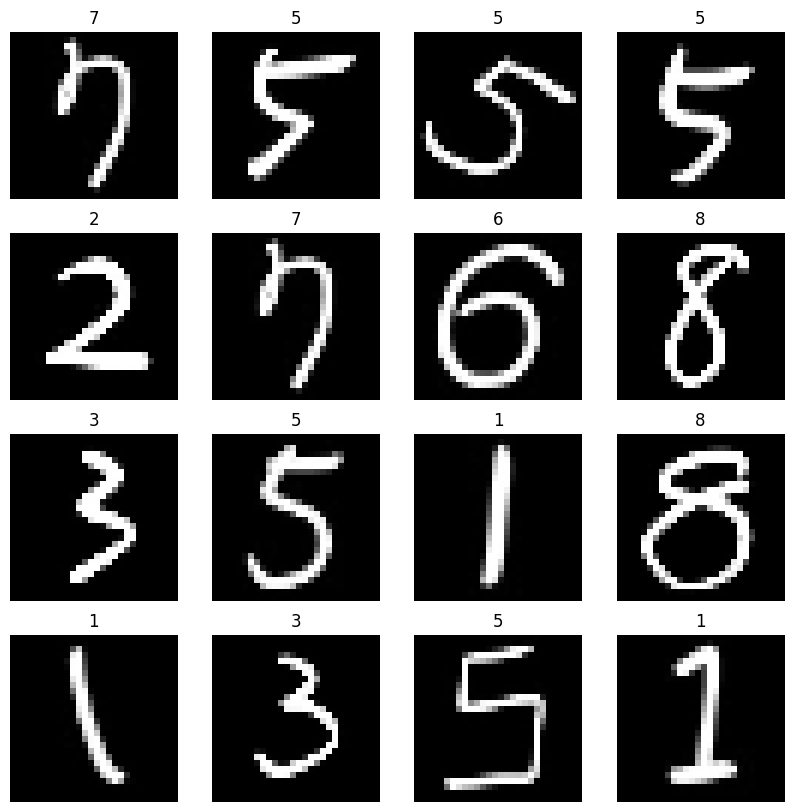

In [10]:
figure = plt.figure(figsize=(10, 10))
cols, rows = 4, 4
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(handwrite_list), size=(1,)).item()
    img, label = handwrite_list[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

Accuracy: 46.19%


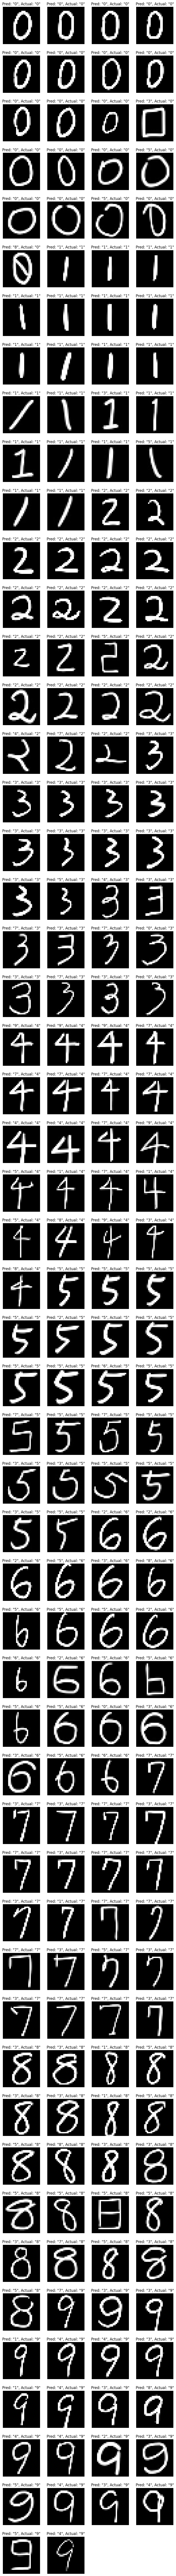

In [21]:
model.eval()
figure1 = plt.figure(figsize=(10, 160))
i, j = 0, 0
for i in range(0, 210):
    figure1.add_subplot(56, 4, i+1)
    x, y = handwrite_list[i][0], handwrite_list[i][1]
    with torch.no_grad():
        pred = model(x)
        predicted, actual = pred[0].argmax(0), y
        img, label = handwrite_list[i]
        plt.title(f'Pred: "{predicted}", Actual: "{actual}"')
        plt.axis("off")
        plt.imshow(img.squeeze(), cmap = "gray")
        if predicted == actual:
            j += 1
hand_acc = j/len(handwrite_list)*100
print(f"Accuracy: {hand_acc:.2f}%")
plt.show()    